In [1]:
from gwsolverfull import GWSolver

import numpy as np

from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_kanamori, h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from triqs.atom_diag import *
import numpy as np
import sympy as sp
from itertools import product
import matplotlib.pylab as plt

In [2]:
spin_names = ['up', 'dn']
orbitals = 3
orbital_names = range(orbitals)

beta = 100
U = 1.0
t = 1.0
mu = 0
N_fix = 2

V = np.zeros([orbitals] * 4)
for i in range(orbitals):
    V[i, i, i, i] = U

V[0, 0, 1, 1] = U / 2
V[1, 1, 0, 0] = U / 2


tij = np.zeros([orbitals] * 2)
for i in range(orbitals - 1):
    tij[i, i + 1] = t
    tij[i + 1, i] = t

fops = [(sn, on) for sn, on in product(spin_names, orbital_names)]

N_up = n('up', 0) + n('up', 1)
N_dn = n('dn', 0) + n('dn', 1)
N = N_up + N_dn

H = mu * (N_up + N_dn)

H += h_int_slater(spin_names, len(orbital_names), V, off_diag=True, complex=True)

for s, o1, o2 in product(spin_names, orbital_names, orbital_names):
    H += -0.5*(        tij[int(o1),int(o2)]  * c_dag(s,o1) * c(s,o2) + 
              np.conj(tij[int(o1),int(o2)]) * c_dag(s,o2) * c(s,o1))
    

ad = AtomDiagComplex(H, fops)

gf_struct = [('dn', len(orbital_names)),
             ('up', len(orbital_names))]

G_iw = atomic_g_iw(ad, beta, gf_struct, 10 * 1024)
wf = [w.imag for w in G_iw.mesh.values()]
w_mesh = MeshReFreq(window = (wf[0], wf[-1]), n_w = len(wf))

g_inv = Gf(mesh = G_iw.mesh, target_shape = np.shape(tij))
g_inv << iOmega_n + tij
g = g_inv.inverse()
g0_w = BlockGf(block_list = [g] * 2, name_list = spin_names)

gw = GWSolver(g0_w, V, self_interactions = False, hartree_flag = True, fock_flag = True)
g_iw = gw.g_w

# realg = Gf(mesh = w_mesh, target_shape = np.shape(tij))
# G_w = BlockGf(block_list = [realg] * 2, name_list = spin_names)
# g_w = BlockGf(block_list = [realg] * 2, name_list = spin_names)

# for name, g in G_w:
#     G_w[name].set_from_pade(G_iw[name])
#     g_w[name].set_from_pade(g_iw[name])

In [3]:
def number_of_particles(g_w):
    N = 0
    for name, g in g_w:
        N += np.sum(np.diag(g.density())).real
    return N


def compareOrbitals(orbitals, ratio):
    spin_names = ['up', 'dn']
    orbital_names = range(orbitals)

    beta = 100
    t = 1.0
    mu = 0

    U = t / ratio

    V = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        V[i, i, i, i] = U

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = t
        tij[i + 1, i] = t

    fops = [(sn, on) for sn, on in product(spin_names, orbital_names)]

    N_up = n('up', 0) + n('up', 1)
    N_dn = n('dn', 0) + n('dn', 1)
    N = N_up + N_dn

    H = mu * (N_up + N_dn)

    H += h_int_slater(spin_names, len(orbital_names), V, off_diag=True, complex=True)

    for s, o1, o2 in product(spin_names, orbital_names, orbital_names):
        H += -0.5*(        tij[int(o1),int(o2)]  * c_dag(s,o1) * c(s,o2) + 
                np.conj(tij[int(o1),int(o2)]) * c_dag(s,o2) * c(s,o1))
        
    # step = 0.001
    # while True:
    #     ad = AtomDiagComplex(H, fops, n_min = orbitals - 1, n_max = orbitals + 1)
    #     dm = atomic_density_matrix(ad, beta)
    #     filling = trace_rho_op(dm, N, ad)

    #     if abs(filling.real - orbitals) < 1.0e-4:
    #         break
    #     elif filling.real < orbitals:
    #         H += -step * N
    #     elif filling.real > orbitals:
    #         H += 0.1 * step * N
        
    # ad = AtomDiagComplex(H, fops, n_min = orbitals - 1, n_max = orbitals + 1)
    ad = AtomDiagComplex(H, fops)


    gf_struct = [('dn', len(orbital_names)),
                ('up', len(orbital_names))]

    G_w = atomic_g_iw(ad, beta, gf_struct, 10 * 1024)


    # print(number_of_particles(G_w))

    wf = [w.imag for w in G_w.mesh.values()]


    g_inv = Gf(mesh = G_w.mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n + tij
    g = g_inv.inverse()
    g0_w = BlockGf(block_list = [g] * 2, name_list = spin_names)

    gw = GWSolver(g0_w, V, hartree_flag = True, fock_flag = True)
    g_w = gw.g_w
    # print(number_of_particles(g_w))


    fig, axs = plt.subplots(orbitals, orbitals, figsize = (5 * orbitals, 5 * orbitals), facecolor = 'black')
    s = 5

    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-5, 5)


            axs[i, j].plot(wf, G_w['up'].data[:, i, j].real, color = 'white', zorder = 0)
            axs[i, j].plot(wf, G_w['up'].data[:, i, j].imag, color = 'white', zorder = 0)

            axs[i, j].scatter(wf, g_w['up'].data[:, i, j].real, color = 'red', s = s, zorder = 1)
            axs[i, j].scatter(wf, g_w['up'].data[:, i, j].imag, color = 'blue', s = s, zorder = 1)

    
    return

In [8]:
def greensfunctions(orbitals, ratio):
    spin_names = ['up', 'dn']
    orbital_names = range(orbitals)

    beta = 100
    t = 1.0
    U =  t / ratio
    mu = 0
    
    V = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        V[i, i, i, i] = U

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = t
        tij[i + 1, i] = t

    fops = [(sn, on) for sn, on in product(spin_names, orbital_names)]

    N_up = n('up', 0) + n('up', 1)
    N_dn = n('dn', 0) + n('dn', 1)
    N = N_up + N_dn

    H = mu * (N_up + N_dn)

    H += h_int_slater(spin_names, len(orbital_names), V, off_diag=True, complex=True)

    for s, o1, o2 in product(spin_names, orbital_names, orbital_names):
        H += -0.5*(        tij[int(o1),int(o2)]  * c_dag(s,o1) * c(s,o2) + 
                np.conj(tij[int(o1),int(o2)]) * c_dag(s,o2) * c(s,o1))
        
    ad = AtomDiagComplex(H, fops)

    gf_struct = [('dn', len(orbital_names)),
                ('up', len(orbital_names))]

    G_w = atomic_g_iw(ad, beta, gf_struct, 10 * 1024)


    g_inv = Gf(mesh = G_w.mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n + tij
    g = g_inv.inverse()
    g0_w = BlockGf(block_list = [g] * 2, name_list = spin_names)

    gw = GWSolver(g0_w, V, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = orbitals)
    g_w = gw.g_w

    return G_w, g_w

def interactions(orbitals):

    ratios = [1000, 100, 10, 1, 0.5, 0.25, 0.1]
    # ratios = [200]

    fig, axs = plt.subplots(1, len(ratios), figsize = (5 * len(ratios), 5), facecolor = 'black')

    for i, ratio in enumerate(ratios):
        G_iw, g_iw = greensfunctions(orbitals, ratio)
        print("G_w", number_of_particles(G_iw))
        print("g_w", number_of_particles(g_iw))
        w = [iw.imag for iw in G_iw.mesh.values()]

        axs[i].set_facecolor('black')
        axs[i].xaxis.label.set_color('white')
        axs[i].tick_params(axis = 'x', colors = 'white')
        axs[i].yaxis.label.set_color('white')
        axs[i].tick_params(axis = 'y', colors = 'white')

        axs[i].set_xlim(-3, 3)
        axs[i].set_title("t / U = {}".format(ratio), color = 'white', fontsize = 25)

        axs[i].plot(w, -np.imag(np.trace(G_iw['up'].data[:, :, :], axis1 = 1, axis2 = 2))-np.imag(np.trace(G_iw['dn'].data[:, :, :], axis1 = 1, axis2 = 2)), color = 'white', zorder = 0)
        axs[i].scatter(w, -np.imag(np.trace(g_iw['up'].data[:, :, :], axis1 = 1, axis2 = 2))-np.imag(np.trace(g_iw['dn'].data[:, :, :], axis1 = 1, axis2 = 2)), color = 'red', zorder = 1)
    plt.show()
    return

G_w 1.9999999999984137
g_w 1.999909200794944
G_w 1.999999999984045
g_w 1.9999092564428027
G_w 1.9999999998398441
g_w 1.9999146580336618
G_w 1.9999999976097758
g_w 1.9949242875771305
G_w 1.999999990327299
g_w 1.9912187947053326
Max iter reached in finding chemical potential.
G_w 0.9999999826315062
g_w 2.5570045115146476
Max iter reached in finding chemical potential.
G_w 0.9999995538817608
g_w 2.857826426505964


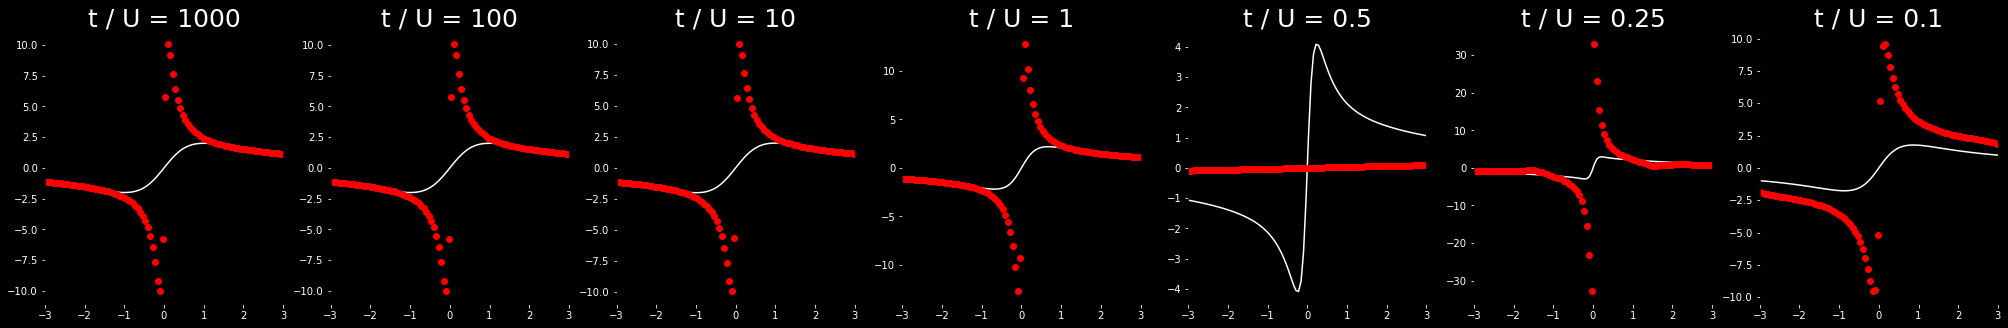

In [9]:
interactions(2)